Extracting data for 79 SNP(s) from 1 GWAS(s)
Harmonising Body mass index || id:ieu-a-2 (ieu-a-2) and Coronary heart disease || id:ieu-a-7 (ieu-a-7)


C:\Users\nkpat\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:921: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\nkpat\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
c:\Users\nkpat\Desktop\MR\mr_egger_regression.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x == 0] = 1
c:\Users\nkpat\Desktop\MR\mr_egger_regression.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

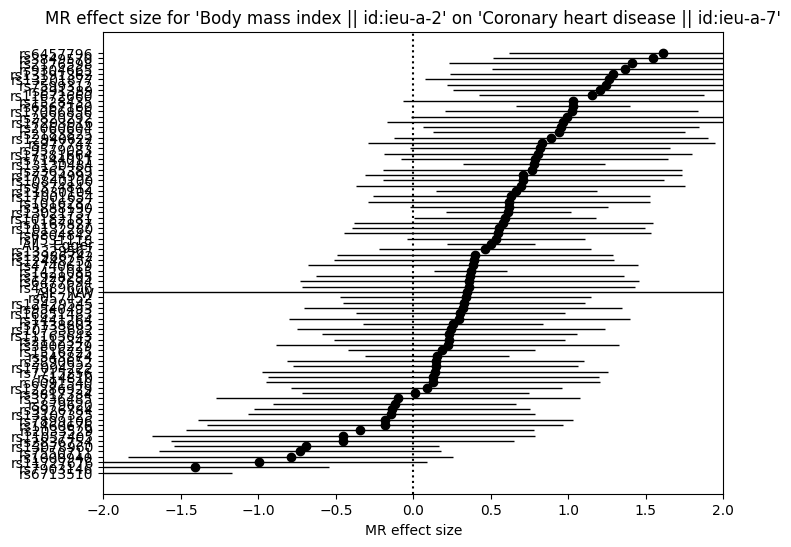

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mr_singlesnp import mr_singlesnp
from extract_instruments import extract_instruments
from extract_outcome_data import extract_outcome_data
from harmonise_data import harmonise_data
def mr_forest_plot(singlesnp_results, exponentiate=False):
    """
    Create a forest plot for the MR effect sizes with optional exponentiation.

    Parameters:
    - singlesnp_results (pandas DataFrame): Dataframe containing the per-SNP MR results.
    - exponentiate (bool, optional): Whether to exponentiate the MR effect sizes or not. Default is False.

    Returns:
    - None
    """
    def blank_plot(message):
        """
        Display a blank plot with a message.

        Parameters:
        - message (str): Message to display on the plot.

        Returns:
        - None
        """
        plt.text(0.5, 0.5, message, ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    def ordered(data, levels):
        """
        Order the data based on the given levels.

        Parameters:
        - data (pandas Series): The data to be ordered.
        - levels (list): The ordered levels to apply.

        Returns:
        - pd.Categorical: The data with applied ordered levels.
        """
        return pd.Categorical(data, categories=levels, ordered=True)
    
    def ordered_grouped(df, by_cols, levels):
        """
        Group the data and apply ordered levels within each group.

        Parameters:
        - df (pandas DataFrame): The data to be grouped and ordered.
        - by_cols (list): Columns used for grouping.
        - levels (list): The ordered levels to apply.

        Returns:
        - pandas DataFrame: The grouped and ordered data.
        """
        return df.groupby(by=by_cols, group_keys=False).apply(lambda d: ordered(d, levels))
    
    res = singlesnp_results.groupby(["id.exposure", "id.outcome"]).apply(lambda d: 
        pd.concat([d,
                   pd.DataFrame({
                       "up": d["b"] + 1.96 * d["se"],
                       "lo": d["b"] - 1.96 * d["se"],
                       "tot": 0.01,
                   })], axis=1))
    
    # Update SNP level names
    res["SNP"] = res["SNP"].replace({"All - Inverse variance weighted": "All - IVW",
                                     "All - MR Egger": "All - Egger"})
    
    # Filter insufficient number of SNPs
    res = res.groupby(["id.exposure", "id.outcome"]).apply(lambda d: d if sum(d["SNP"] != "All - Inverse variance weighted") >= 2 else blank_plot("Insufficient number of SNPs"))
    
    # Separate rows for "All" and other SNPs
    res["tot"] = np.where(res["SNP"] == "All - Inverse variance weighted", 1, 0)
    
    # Sort by effect size
    res = res.sort_values(by=["b"])
    
    # Add an empty row with NaNs
    res.loc[res.index[-1] + 1] = [np.nan] * len(res.columns)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    if exponentiate:
        res["b"] = np.exp(res["b"])
        res["up"] = np.exp(res["up"])
        res["lo"] = np.exp(res["lo"])
    
    for (id_exposure, id_outcome), data in res.groupby(["id.exposure", "id.outcome"]):
        exposure_label = data["exposure"].iloc[0]
        outcome_label = data["outcome"].iloc[0]
        
        plt.plot(data["b"], data["SNP"], 'o', color='black')
        plt.errorbar(data["b"], data["SNP"], xerr=[data["b"] - data["lo"], data["up"] - data["b"]], fmt='none', ecolor='black', elinewidth=1)
        plt.axvline(x=0, linestyle='dotted', color='black')
        
        if data["SNP"].str.strip().eq('').any():
            empty_row_index = data[data["SNP"].str.strip().eq('')].index[0]
            plt.axhline(y=empty_row_index, color='grey')
        
        plt.xlabel("MR effect size" + (" (exponentiated)" if exponentiate else ""))
        plt.ylabel("")
        plt.title(f"MR effect size for '{exposure_label}' on '{outcome_label}'")
    
    plt.xlim(-2, 2)
    plt.show()



# exp = extract_instruments("ieu-a-2")
# out = extract_outcome_data(snps=exp["SNP"], outcomes=["ieu-a-7"])

# dat = harmonise_data(exp, out)

# res = mr_singlesnp(dat)

# mr_forest_plot(res)

